Notebook parameters (used by [Papermill](https://papermill.readthedocs.io/en/latest/))

In [ ]:
insee_population_data_csv = "../data/carroyage_insee_metro.csv"
data_osm_pbf = "../data/aubagne.pbf"
output_geojson = "../data/dummy_count_indicator.geojson"

# Driving network

In [ ]:
import geopandas as gpd
from pyrosm import OSM

In [ ]:
osm = OSM(data_osm_pbf)

In [ ]:
drive_net = osm.get_network(network_type="driving")

In [ ]:
drive_net.plot(figsize=(10,10))

# Population

In [ ]:
from shapely import wkt
import pandas as pd
import geopandas as gpd

In [20]:
# Load France population data
pop_df = pd.read_csv(insee_population_data_csv, usecols=['idINSPIRE', 'id', 'WKT'])
pop_df

WKT  \
0        POLYGON((2.6529953850426 46.440123156379,2.655...   
1        POLYGON((6.679135345427 46.191522591301,6.6817...   
2        POLYGON((-1.9122518974954 48.142412902797,-1.9...   
3        POLYGON((3.2312378220814 46.926350456766,3.233...   
4        POLYGON((6.6327096470269 47.992073373622,6.635...   
...                                                    ...   
2278208  POLYGON((5.0629139392918 45.038648052437,5.065...   
2278209  POLYGON((-2.3124677866276 48.305541160676,-2.3...   
2278210  POLYGON((7.3029741343078 48.041167374581,7.305...   
2278211  POLYGON((3.2787448911711 48.132139530491,3.281...   
2278212  POLYGON((-1.0904114405767 48.170591959153,-1.0...   

                              idINSPIRE                     id  
0        CRS3035RES200mN2619600E3756800  LAEA200M_N13098E18784  
1        CRS3035RES200mN2569800E4064400  LAEA200M_N12849E20322  
2        CRS3035RES200mN2852200E3438400  LAEA200M_N14261E17192  
3        CRS3035RES200mN2669200E3805800  LAEA200M_N13346E19029  
4        CRS3035RES200mN2769800E4069600  LAEA200M_N13849E20348  
...                                 ...                    ...  
2278208  CRS3035RES200mN2449000E3931600  LAEA200M_N12245E19658  
2278209  CRS3035RES200mN2875000E3412000  LAEA200M_N14375E17060  
2278210  CRS3035RES200mN2773200E4119800  LAEA200M_N13866E20599  
2278211  CRS3035RES200mN2802400E3821200  LAEA200M_N14012E19106  
2278212  CRS3035RES200mN2845800E3499200  LAEA200M_N14229E17496  

[2278213 rows x 3 columns]

In [ ]:
geometry = pop_df.WKT.apply(wkt.loads)

In [ ]:
carreaux_gdf = gpd.GeoDataFrame(pop_df, crs='EPSG:4326', geometry=geometry)
carreaux_gdf

In [ ]:
del pop_df

# Intersection

Intersect population data with driving network.

In [ ]:
intersect_gdf = gpd.sjoin(carreaux_gdf, drive_net, op="intersects")
intersect_gdf

In [ ]:
intersect_gdf.plot()

In [29]:
indicator_gdf = gpd.GeoDataFrame([
    {"id": id_left, "idINSPIRE": sub_df.idINSPIRE.iloc[0], "count": len(sub_df), "geometry": sub_df.geometry.iloc[0]}
    for id_left, sub_df in intersect_gdf.groupby("id_left")
]).set_index("id")

In [31]:
def plot_all():
    figsize = (20,100)
    minx, miny, maxx, maxy = indicator_gdf.total_bounds
    ax = drive_net.plot(figsize=figsize)
    # margins
    xm = (maxx - minx) * 0.1
    ym = (maxy - miny) * 0.1
    ax.set_xlim(minx - xm, maxx + xm)
    ax.set_ylim(miny - ym, maxy + ym)
    indicator_gdf.plot(ax=ax, alpha=0.5, edgecolor='k', figsize=figsize)

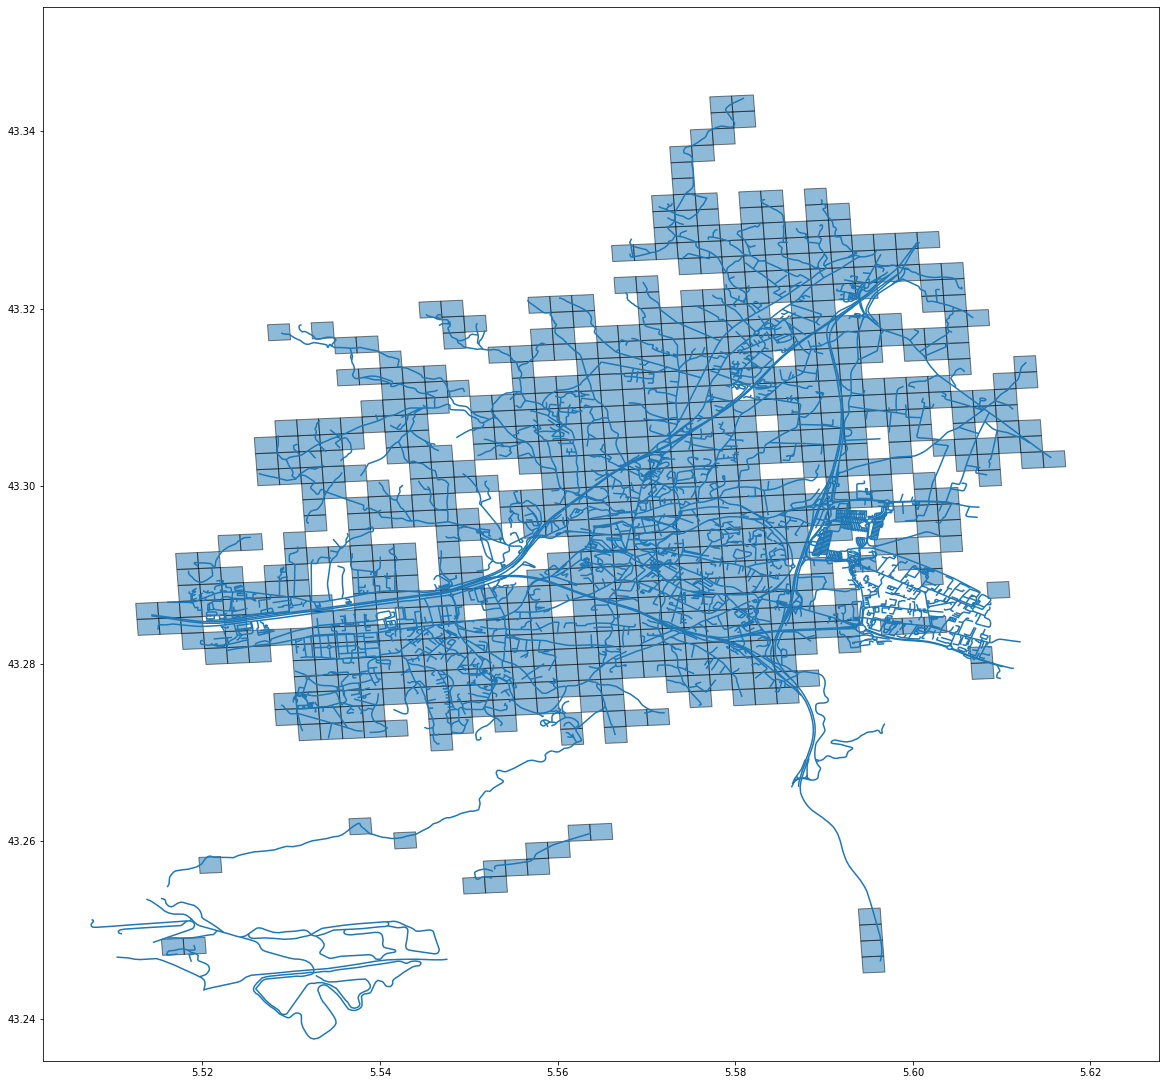

In [32]:
plot_all()

In [33]:
indicator_gdf.to_file(output_geojson, driver='GeoJSON')